In [1]:
import pandas as pd
import numpy as np
import os
import json
import random
import math
from tqdm import notebook # Library for displaying progress bar
np.random.seed(500)

# Set the desired bin size
bin_size = 15

First we select a pair of snapshots, the lower index is the input and the higher index is the output. Then combined bins together based on the number of desired bins. Ie if the bin size is 15, every 10 bins will be combined into one. Y is randomnly sampled from the bins. 

Tried the following transformations:
- None
- Log space
- 1 / log space
- normalized output
- normalized input and output

In [2]:
def process_sample(i, snapshot_count, rhod, time, bin_size=15, num_bins=151):
    """ Creates a training sample from two points in time. Selects a random output bin for y, and saves the output bins for comparison"""
    # First sample will always be the first and last element
    if i == 0:
        idxs = [0, snapshot_count-1]
    else:
        # Pick two indexes for snapshots (lowest = input, highest = output)
        idxs = sorted([random.randint(0,snapshot_count-1) for _ in range(2)])
    input_a = rhod[idxs[0]]
    output_a = rhod[idxs[1]]

    new_input_bins = []
    new_output_bins = []
    input_bin_sum = np.sum(input_a)
    output_bin_sum = np.sum(output_a)
    for i in range(bin_size):
        # Get the start index of the bin
        start = i * math.floor(num_bins/bin_size)
        # Get the end index
        end = (i+1) * math.floor(num_bins/bin_size)
        # Include bin 150 in the last new bin (151 does not divide into 15 evenly for example)
        if i == bin_size-1:
            end+=num_bins % bin_size
            
        # Get the old bins and sum them together to create the new one
        # Also normalize the input bins
        # Could add a statement here to leave out one of the input bins
        new_input_bin = np.sum(input_a[start:end]) / input_bin_sum
        new_input_bins.append(new_input_bin)
        
        # Normalize the output bin so we can compare the prob distribution to it
        new_output_bin = np.sum(output_a[start:end]) / output_bin_sum
        new_output_bins.append(new_output_bin)
        
    # Select the highest density bin => highest prob
    y = np.argmax(new_output_bins)
    # Time of the input
    t = time[idxs[0]]
        
    # Difference of time in seconds between two snapshots
    delta_t = time[idxs[1]] - t
    
    row = np.concatenate([input_params,new_input_bins,[t, delta_t, y], new_output_bins])
    return row

def write_to_file(data, header=True, bin_size=15, batch=False):
    """ Helper method to write training data to a file"""
    columns = ['R', 'Mstar', 'alpha', 'd2g', 'sigma', 'Tgas'] + [f'Input_Bin_{i}' for i in range(bin_size)] + ['t','Delta_t', 'y'] + [f'Output_Bin_{i}' for i in range(bin_size)]
    df = pd.DataFrame(res, columns=columns)

    # If writing in batch set the file mode to append
    mode = 'a' if batch else 'w'
    df.to_csv(filename, chunksize=100000, mode=mode, header=header, index=False)

In [3]:
# Sets the output filename
filename = 'dust_training_data_ordered_logit_bin_15.csv'
root_data_path = "/project/SDS-capstones-kropko21/uva-astronomy/data/dust_coag_data_v1"
data_group = "combined_v1"

# Store formatted data for training
res = []

chunk_size = 1000
# Set this to a smaller number to get a smaller training set
model_count = 10000
writes = 0
for d in notebook.tqdm(range(model_count)):
    data_set = data_set = str(d).zfill(5)

    data_dir = f"{root_data_path}/{data_group}/data_{data_set}"

    input_params = None
    # Open and extract the input parameters
    with open(os.path.join(root_data_path, "model_dict_v1.json")) as f:
        model_dict = json.load(f)
        input_dict = model_dict[data_set]
        input_params = [input_dict['R'], input_dict['Mstar'], input_dict['alpha'],input_dict['d2g'], input_dict['sigma'], input_dict['Tgas']]

    try:
        # `rho_dat`: The dust mass density (in g/cm^3) in each particle size/bin at a given snapshot in time. This is the main "output", i.e., the primary result, of any given model.
        rhod = np.loadtxt(os.path.join(data_dir,"rho_d.dat"))
        # Replace NaNs with 0s
        rhod = np.nan_to_num(rhod)
        # Replace negative values with 0s
        rhod = np.where(rhod<0, 0, rhod) 
        
        # `a_grid.dat`: The dust particle size in each "bin" in centimeters.
        a_grid = np.loadtxt(os.path.join(data_dir, 'a_grid.dat'))

        # `time.dat`: The time of each snapshot (in seconds).
        time = np.loadtxt(os.path.join(data_dir, "time.dat"))
    except Exception as e:
        print(f'model {d} skipped')
        import traceback
        print(traceback.print_exc())
        continue

    snapshot_count = len(rhod)

    # Set the number of samples
    if snapshot_count > 15:
        # Set the max to 100 for time as 15 cHr 2 is about 100
        samples = 100
    else:
        # The number of pairs
        samples = int(math.factorial(snapshot_count) / math.factorial(2) / math.factorial(snapshot_count-2))
    
    samples += 1
    for i in range(samples):
        row = process_sample(i, snapshot_count, rhod, time, bin_size=bin_size)
        res.append(row)
        
    # Write to csv every x models to avoid oom
    if d != 0 and d % chunk_size == (model_count - 1) % chunk_size:
        writes += 1
        # Only write the header on first chunk
        header = writes == 1
        write_to_file(res, header, bin_size=bin_size, batch=True)
        res = []
    
# Write out the entire file at the end
#write_to_file(res)

In [19]:
read_df = pd.read_csv(filename)
read_df['y'].describe()

count    800338.000000
mean          8.764769
std           4.061286
min           0.000000
25%           5.000000
50%           8.000000
75%          14.000000
max          14.000000
Name: y, dtype: float64

Now we split the data into train and test and use the mord package for ordered logistic regression. We extracted the probabilities and scored the model fit with negagative mean absolute error.

In [20]:
#%pip install mord
import mord
from sklearn.model_selection import train_test_split

def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column must be y """
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except y column and the output bins for the predictors
    data_set_X = data_set.drop(['y'] + [f'Output_Bin_{i}' for i in range(bin_size)], axis=1)
    
    # Select just y column and output bins
    data_set_Y = data_set[['y'] + [f'Output_Bin_{i}' for i in range(bin_size)]]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)


X_train, X_test, y_train, y_test = create_test_train(filename)
y_train = y_train.astype(int)

logistic_model = mord.LogisticIT()
# Fit only on the y column
logistic_model.fit(X_train, y_train['y'])

# Obtain the probability distribution of the class
probs = logistic_model.predict_proba(X_test)

# Obtain the negative mean absolute error
score = logistic_model.score(X_test, y_test['y'])
print(score)

0.04461853712172327


In [16]:
# Output the counts of our labels
pd.read_csv("dust_training_data_ordered_logit_bin_15_3.csv")['y'].value_counts()

14.0    211155
5.0     145464
6.0      83189
7.0      56260
8.0      44278
9.0      38514
10.0     36641
11.0     33810
4.0      32672
12.0     32648
13.0     27744
2.0      22071
3.0      21279
1.0       8049
0.0       6564
Name: y, dtype: int64

We made a plot of an observation and the predicted probability distribution. We also calculated the entropy for each test observation and the predicted observation which is the Kullback-Leibler divergence.

On the full models with a bin size of 15, entropy averaged around 2.4 which is not good.

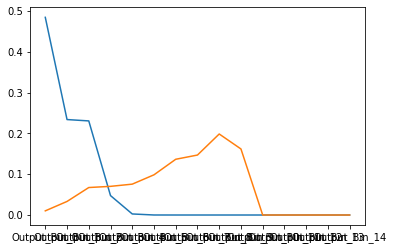

                  0
count  8.003400e+04
mean            inf
std             NaN
min    2.924173e-02
25%    1.838672e+00
50%    4.785313e+00
75%    8.988624e+01
max             inf


In [17]:
import scipy
from scipy.stats import entropy, kstest

# Select a test observation to graph
test_obs = probs[5]
cols = [f'Output_Bin_{i}' for i in range(bin_size)]

# Get the true distribution
y_obs = y_test.iloc[5][cols]

# Plot the two together
from matplotlib import pyplot as plt
plt.plot(test_obs)
plt.plot(y_obs)
plt.show()

# Get entropy for all
entropys = []
for idx, prob in enumerate(probs):
    output = y_test.iloc[idx][[f'Output_Bin_{i}' for i in range(bin_size)]]
    # To compute the entropies, the length of the probability list and the bin list must be equal
    # If your training data does not include all bins, you'll need to fill in 0s for the probability matrix
    ent = entropy(prob, output.values)
    entropys.append(ent)
df_entropy = pd.DataFrame(entropys)
print(df_entropy.describe())


In [18]:
# Display the model coefficients
print(logistic_model.coef_)

[-5.15298288e-23  5.80540773e-24  2.69150998e-26  1.78947012e-24
  9.14962892e-21  4.39465665e-22 -2.22703317e-26  1.46813180e-26
  5.03214764e-26  1.10979688e-25  1.74615718e-25  3.23155405e-25
  4.82906037e-25  3.87693633e-25  3.17759735e-25  2.83035150e-25
  2.69138010e-25  2.63337020e-25  2.40053014e-25  1.80604592e-25
  2.72939726e-24  1.26821992e-12  2.31768036e-12]
